In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
def show_tables():
    q='''SELECT
    name,
    type
    FROM sqlite_master
    WHERE type IN ("table","view")'''
    return run_query(q)
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [2]:
q1='''SELECT COUNT(customer_id), SUM(total) FROM invoice     
      LIMIT 50'''
run_query(q1)
          

,COUNT(customer_id),SUM(total)
0,614,4709.43


In [3]:
q2='''WITH tracks_sold_USA_by_genre AS
          (
           SELECT g.name genre, COUNT(i.invoice_id) tracks_sold FROM customer c
           INNER JOIN invoice i ON i.customer_id = c.customer_id
           INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
           INNER JOIN track t ON t.track_id = il.track_id
           INNER JOIN genre g ON g.genre_id = t.genre_id
           WHERE c.country = "USA"  
           GROUP BY genre
           ORDER BY tracks_sold DESC           
          )
      SELECT genre, tracks_sold, CAST(tracks_sold AS FLOAT)/(SELECT SUM(tracks_sold) FROM tracks_sold_USA_by_GENRE) percentage_sold FROM tracks_sold_USA_by_genre
      LIMIT 10
              
           '''
run_query(q2)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


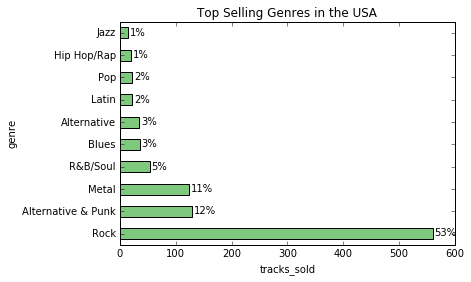

In [4]:
%matplotlib inline
top_genres_usa=run_query(q2)
#top_genres_usa.set_index('genre',inplace=True, drop=True)
ax=top_genres_usa.plot.barh(x='genre', y='tracks_sold', legend = None, colormap=plt.cm.Accent)
ax.set_xlabel('tracks_sold')
ax.set_title('Top Selling Genres in the USA')
label1=top_genres_usa['percentage_sold'].multiply(other=100).astype(int).astype(str) + "%" 
labels=label1.tolist()
rects=ax.patches
height=[]
x_val_l=[]
wd_val=[]
i=0
for rect, label in zip(rects, labels):
#     height.append(rect.get_height())
#     x_val_l.append(rect.get_x())
#     wd_val.append(rect.get_width())
    #print(rect.get_width()+5, rect.get_height()+i)
    ax.text(rect.get_width()+3, i-0.1, label)
    i=i+1

Finished most of them - Just need to make sure the graph looks sleek

Regarding the recommendation, based on the sales of tracks across different genres in the USA, we should purchase the new albums by the following artists:

Red Tone (Punk)
Slim Jim Bites (Blues)
Meteor and the Girls (Pop)

It's worth keeping in mind that combined, these three genres only make up only 17% of total sales, so we should be on the lookout for artists and albums from the 'rock' genre, which accounts for 53% of sales.

# EMPLOYEE SALES PERFORMANCE

In [5]:
q3='''WITH sales_by_support_agent AS
         (
          SELECT 
          i.customer_id, c.support_rep_id, SUM(i.total) total FROM invoice i
          INNER JOIN customer c ON c.customer_id=i.customer_id
          GROUP BY 1,2          
        )
    SELECT 
    e.first_name || " " || e.last_name employee_name, e.hire_date, SUM(sbsa.total) total_sales FROM sales_by_support_agent sbsa
    INNER JOIN employee e ON e.employee_id = sbsa.support_rep_id
    GROUP BY 1
       '''
run_query(q3)
# WITH sales_by_support_agent AS
#         ( )

,employee_name,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


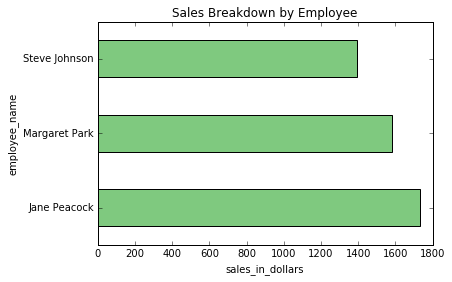

In [6]:
%matplotlib inline
sales_support_agent=run_query(q3)
ax=sales_support_agent.plot.barh(x='employee_name', y='total_sales', legend = None, colormap=plt.cm.Accent)
ax.set_title('Sales Breakdown by Employee')
ax.set_xlabel('sales_in_dollars')
plt.show()

While there is a 20% difference in sales between Jane (the top employee) and Steve (the bottom employee), the difference roughly corresponds with the differences in their hiring dates. Longer the employee in the company, he might have sold more, which reflects in his sales numbers.

In [7]:
q4='''SELECT c.country, COUNT(customer_id) FROM customer c
        GROUP BY 1
        ORDER BY 2 DESC
        '''
run_query(q4)


,country,COUNT(customer_id)
0,USA,13
1,Canada,8
2,Brazil,5
3,France,5
4,Germany,4
5,United Kingdom,3
6,Czech Republic,2
7,India,2
8,Portugal,2
9,Argentina,1


In [8]:
q5='''SELECT c.country, SUM(i.total)  FROM customer c
        INNER JOIN invoice i ON i.customer_id = c.customer_id
        GROUP BY 1
        ORDER BY 2 DESC'''
run_query(q5)

,country,SUM(i.total)
0,USA,1040.49
1,Canada,535.59
2,Brazil,427.68
3,France,389.07
4,Germany,334.62
5,Czech Republic,273.24
6,United Kingdom,245.52
7,Portugal,185.13
8,India,183.15
9,Ireland,114.84


In [9]:
q6='''WITH cust_count AS
        (
        SELECT c.country, COUNT(customer_id) count FROM customer c
        GROUP BY 1
        ORDER BY 2 DESC
        )
        SELECT c.country, cu.count, SUM(i.total) FROM customer c
        INNER JOIN invoice i ON i.customer_id = c.customer_id
        INNER JOIN cust_count cu ON cu.country = c.country
        GROUP BY 1
        ORDER BY 2 DESC
        '''
run_query(q6)

,country,count,SUM(i.total)
0,USA,13,1040.49
1,Canada,8,535.59
2,Brazil,5,427.68
3,France,5,389.07
4,Germany,4,334.62
5,United Kingdom,3,245.52
6,Czech Republic,2,273.24
7,India,2,183.15
8,Portugal,2,185.13
9,Argentina,1,39.60


In [10]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


In [11]:
q7='''SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
          '''
run_query(q7)

,country,customer_id,invoice_line_id,invoice_id,track_id,unit_price,quantity
0,USA,18,1,1,1158,0.99,1
1,USA,18,2,1,1159,0.99,1
2,USA,18,3,1,1160,0.99,1
3,USA,18,4,1,1161,0.99,1
4,USA,18,5,1,1162,0.99,1
5,USA,18,6,1,1163,0.99,1
6,USA,18,7,1,1164,0.99,1
7,USA,18,8,1,1165,0.99,1
8,USA,18,9,1,1166,0.99,1
9,USA,18,10,1,1167,0.99,1


In [12]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


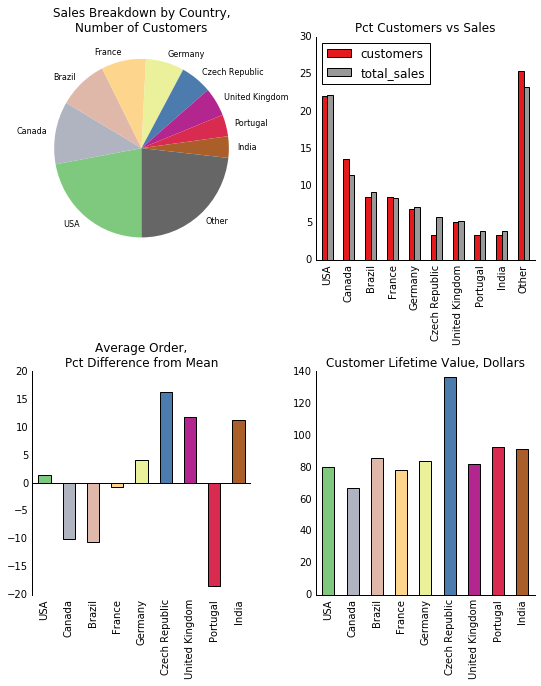

In [13]:
country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

In [14]:
q8='''SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1'''
run_query(q8)

,invoice_id,first_track_id
0,1,1158
1,2,201
2,3,2516
3,4,748
4,5,1986
5,6,30
6,7,42
7,8,81
8,9,196
9,10,2663


In [29]:
q9='''WITH al_tr AS
(
SELECT album_id, COUNT(*) tracks
FROM track
GROUP BY album_id
)

SELECT title album_name, al_tr.album_id, al_tr.tracks FROM album
INNER JOIN al_tr ON album.album_id = al_tr.album_id
ORDER BY 3 DESC

'''
run_query(q9)

,album_name,album_id,tracks
0,Greatest Hits,141,57
1,Minha Historia,23,34
2,Unplugged,73,30
3,"Lost, Season 3",229,26
4,"Lost, Season 1",230,25
5,"The Office, Season 3",251,25
6,My Way: The Best Of Frank Sinatra [Disc 1],83,24
7,"Lost, Season 2",231,24
8,"Battlestar Galactica (Classic), Season 1",253,24
9,Afrociberdelia,24,23


In [54]:
q10='''WITH in_al_tr AS
        (
        SELECT il.invoice_id, tr.album_id, il.track_id FROM invoice_line il
        LEFT JOIN track tr ON tr.track_id = il.track_id
         )
         
        SELECT invoice_id, album_id, COUNT(DISTINCT track_id) FROM in_al_tr
        GROUP BY invoice_id,album_id
        
       '''
run_query(q10)

,invoice_id,album_id,COUNT(DISTINCT track_id)
0,1,91,16
1,2,20,1
2,2,34,1
3,2,39,1
4,2,66,1
5,2,73,1
6,2,134,1
7,2,190,1
8,2,215,1
9,2,218,1


In [41]:
q11='''
SELECT album_id, COUNT(DISTINCT track_id) AS nr_of_tracks
  FROM track
 GROUP BY album_id
 ORDER BY 2 DESC

'''
run_query(q11)

,album_id,nr_of_tracks
0,141,57
1,23,34
2,73,30
3,229,26
4,230,25
5,251,25
6,83,24
7,231,24
8,253,24
9,24,23


In [61]:
q12='''
WITH al_tr AS
(
SELECT album_id, COUNT(*) tracks
FROM track
GROUP BY album_id
),

al_na_tr AS
(
 SELECT title album_name, al_tr.album_id, al_tr.tracks nr_of_tracks FROM album
 INNER JOIN al_tr ON album.album_id = al_tr.album_id
 ORDER BY 3 DESC
),

in_al_tr AS
(
 SELECT il.invoice_id, tr.album_id, il.track_id FROM invoice_line il
 LEFT JOIN track tr ON tr.track_id = il.track_id
),

gr_in_al AS
(      
 SELECT invoice_id, album_id, COUNT(DISTINCT track_id) tracks_purchased FROM in_al_tr
 GROUP BY invoice_id,album_id
),

class_inv_al AS
(
 SELECT gia.*, ant.nr_of_tracks,
		(
		CASE
			WHEN gia.tracks_purchased = nr_of_tracks THEN 1
			WHEN gia.tracks_purchased <> nr_of_tracks THEN 0
			ELSE -9999
		END
		) AS full_album
	FROM gr_in_al gia
    INNER JOIN al_na_tr ant ON gia.album_id = ant.album_id
),

al_y_n AS
(
SELECT invoice_id, MAX(full_album) album_purchased FROM class_inv_al
GROUP BY 1
)

SELECT album_purchased, COUNT(invoice_id), ROUND(
         100*CAST(COUNT(invoice_id) as FLOAT)/(SELECT COUNT(*) FROM al_y_n),
         2) AS pct_of_invoices FROM al_y_n
GROUP BY 1

'''
run_query(q12)

,album_purchased,COUNT(invoice_id),pct_of_invoices
0,0,413,67.26
1,1,201,32.74


Album purchases account for 32.74% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one third of revenue.